# Credit Scoring Model Evaluation (PD)

This notebook provides a comprehensive analysis of model performance across multiple credit scoring datasets. The evaluation covers 14 different models tested on 13 datasets with various experimental configurations including hyperparameter tuning and class imbalance handling.

Note: We removed data from dataset 29 and tabpfn_hpo as we were not able to conduct these experiments for all combinations due to computational limitations. In this evaluation the tuned TabPFN model refers to tabpfn_rf (TabPFN Random Forest)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Load and prepare the dataset
df_raw = pd.read_csv('../outputs/pd/total_combined/total_combined_meta_results.csv')

# Remove dataset 29 and tabpfn_hpo
df = df_raw[(df_raw['dataset'] != '29_loan_default') & (df_raw['model'] != 'tabpfn_hpo')].copy()

# Set original tabpfn as untuned
df.loc[df['model'] == 'tabpfn', 'tuning'] = False

# Change tabpfn_rf to tabpfn tuned
tabpfn_rf_mask = df['model'] == 'tabpfn_rf'
df.loc[tabpfn_rf_mask, 'model'] = 'tabpfn'
df.loc[tabpfn_rf_mask, 'tuning'] = True

print(f"Dataset loaded and cleaned: {df.shape[0]} experiments across {df['dataset'].nunique()} datasets and {df['model'].nunique()} models")
print(f"TabPFN entries - Untuned: {len(df[(df['model'] == 'tabpfn') & (df['tuning'] == False)])}, Tuned: {len(df[(df['model'] == 'tabpfn') & (df['tuning'] == True)])}")

# Create model-tuning combination identifier for analysis
df['model_tuned'] = df['model'] + '_' + df['tuning'].map({True: 'tuned', False: 'untuned'})

ModuleNotFoundError: No module named 'seaborn'

## Experimental Overview

This comprehensive benchmarking study evaluated 14 machine learning models across 13 different credit scoring datasets. Each experiment was conducted with 3-fold cross-validation, resulting in over 3,200 individual model evaluations.

### Experimental Design:
- **Models**: 14 algorithms including ensemble methods (RF, XGBoost, LightGBM, CatBoost), neural networks (ANN, TabNet), TabPFN, and classical methods
- **Datasets**: 13 real-world credit scoring datasets (excluding dataset 29)
- **Imbalance Handling**: Three settings - no handling, moderate rebalancing (0.5 ratio), aggressive rebalancing (0.1 ratio)
- **Hyperparameter Tuning**: Comparison of default vs. tuned parameters
- **TabPFN**: Original TabPFN as untuned baseline, TabPFN-RF as tuned version

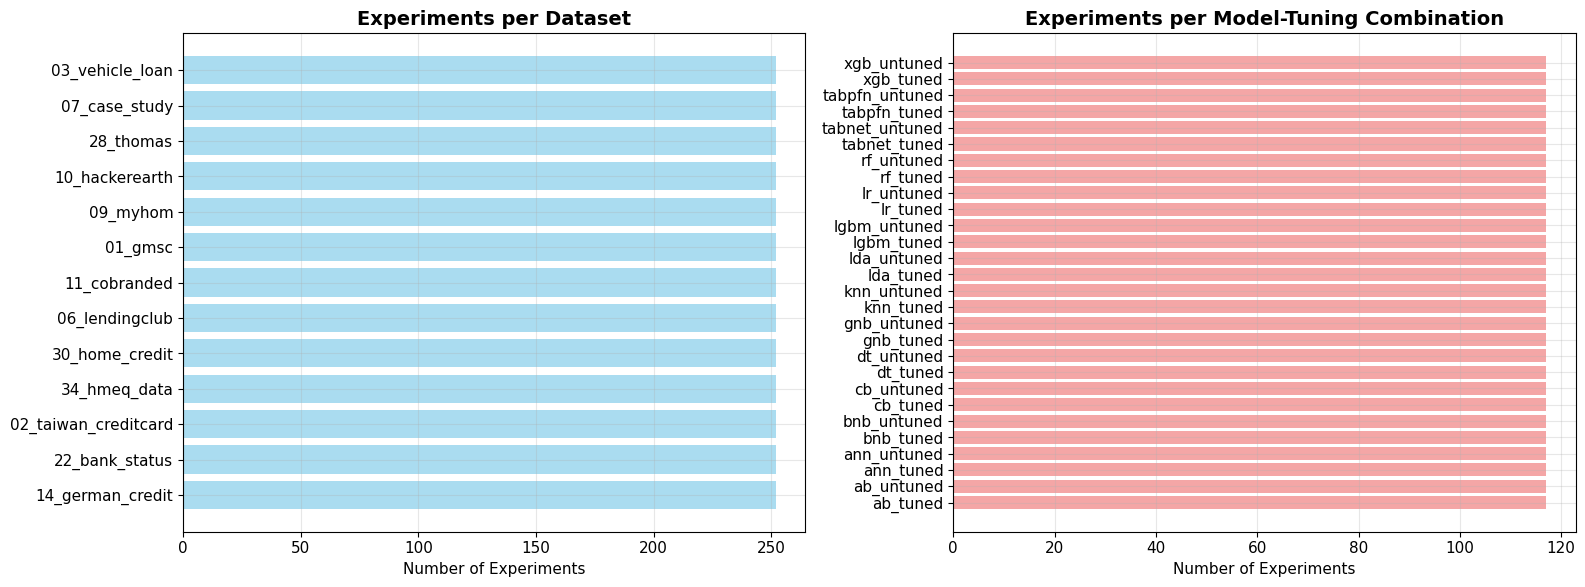


Experimental Setup Summary:
• Total experiments: 3,276
• Datasets evaluated: 13
• Models tested: 14
• Model-tuning combinations: 28
• Cross-validation folds: 3
• Performance metrics: 8 (accuracy, F1, AUC-ROC, precision, recall, etc.)


In [2]:
# Create overview visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Dataset distribution
dataset_counts = df['dataset'].value_counts()
axes[0].barh(range(len(dataset_counts)), dataset_counts.values, color='skyblue', alpha=0.7)
axes[0].set_yticks(range(len(dataset_counts)))
axes[0].set_yticklabels(dataset_counts.index)
axes[0].set_title('Experiments per Dataset', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Experiments')
axes[0].grid(True, alpha=0.3)

# Model distribution (tuned vs untuned)
model_tuning_counts = df['model_tuned'].value_counts().sort_index()
axes[1].barh(range(len(model_tuning_counts)), model_tuning_counts.values, color='lightcoral', alpha=0.7)
axes[1].set_yticks(range(len(model_tuning_counts)))
axes[1].set_yticklabels(model_tuning_counts.index, rotation=0)
axes[1].set_title('Experiments per Model-Tuning Combination', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Experiments')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nExperimental Setup Summary:")
print(f"• Total experiments: {len(df):,}")
print(f"• Datasets evaluated: {df['dataset'].nunique()}")
print(f"• Models tested: {df['model'].nunique()}")
print(f"• Model-tuning combinations: {df['model_tuned'].nunique()}")
print(f"• Cross-validation folds: {df['split'].nunique()}")
print(f"• Performance metrics: 8 (accuracy, F1, AUC-ROC, precision, recall, etc.)")

## Dataset-Specific Performance Analysis

This section examines how different models perform across various datasets, helping identify which models are most suitable for different types of credit scoring tasks.

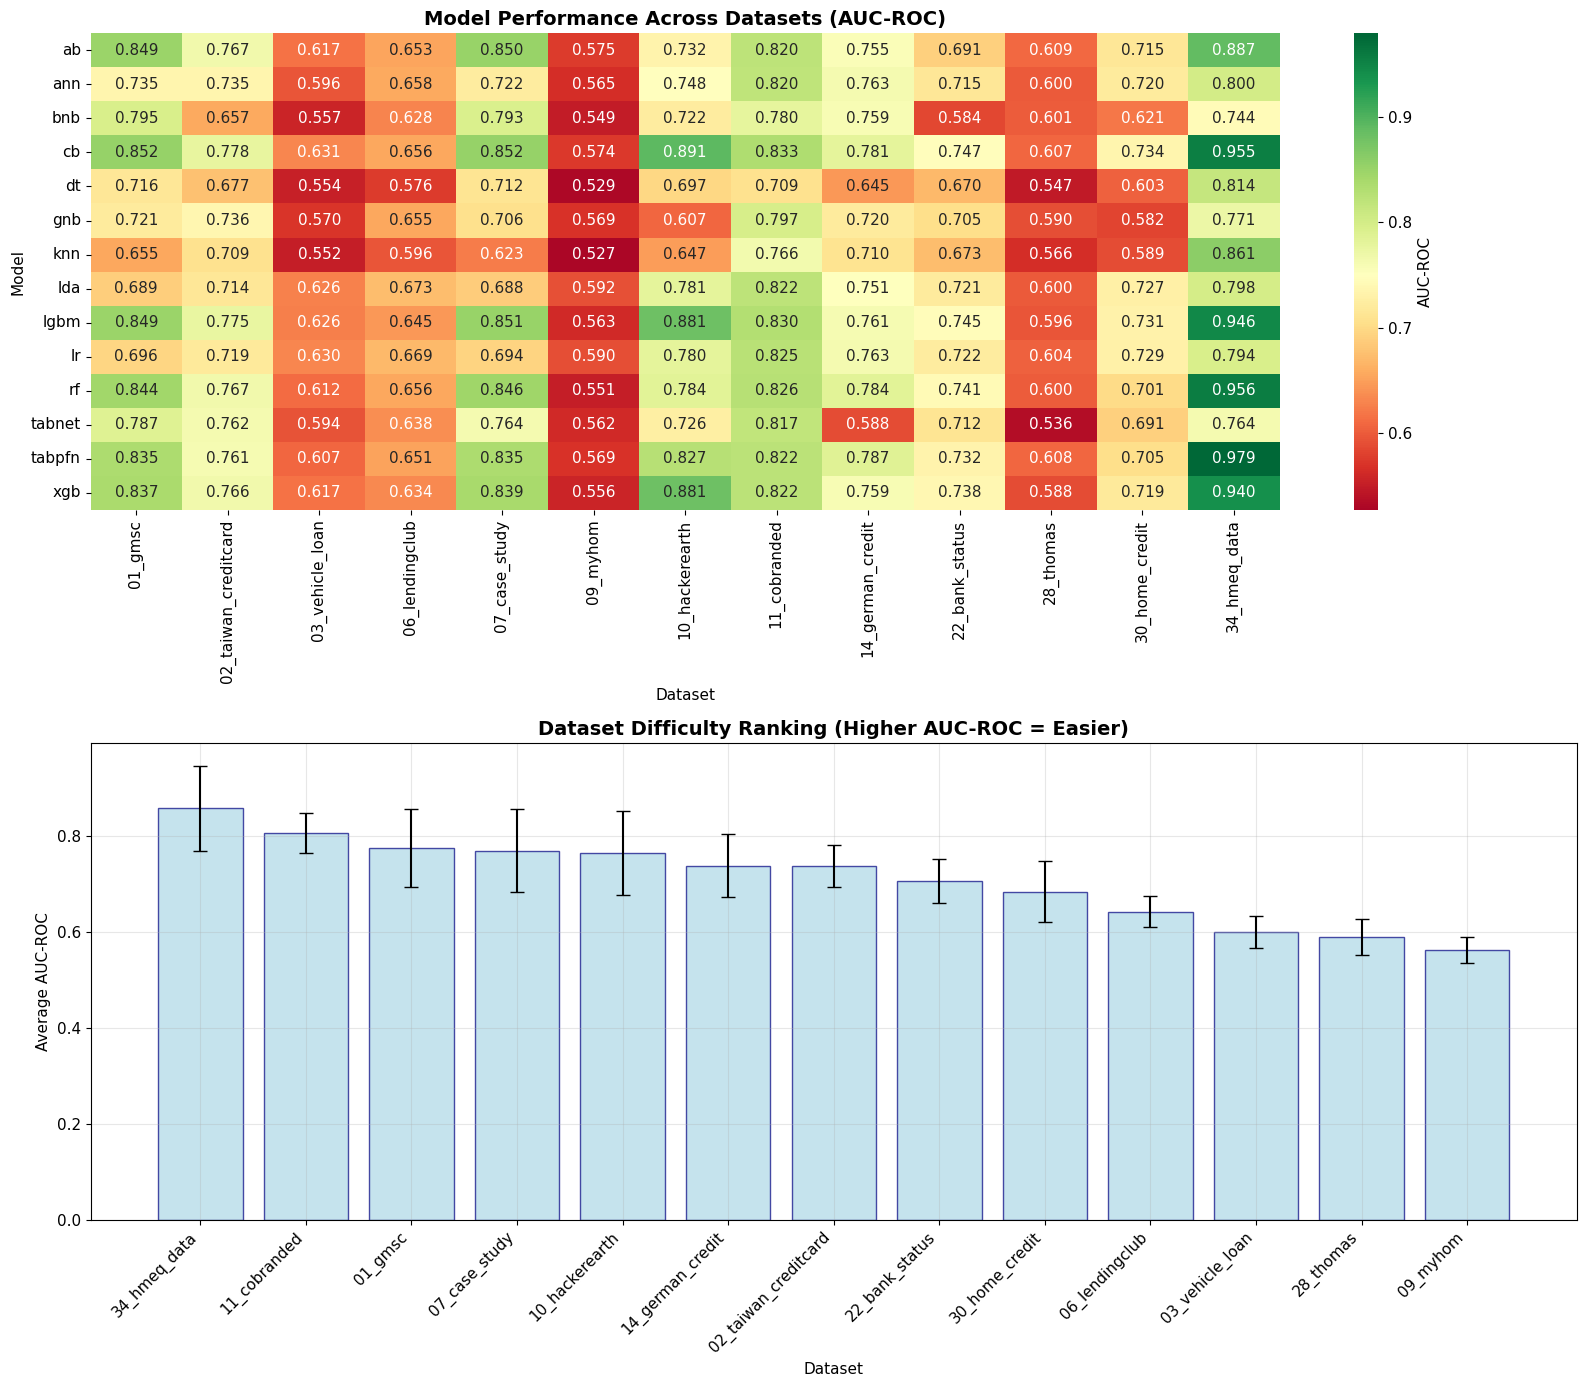


Best Model for Each Dataset:
01_gmsc: cb (AUC-ROC: 0.8525)
02_taiwan_creditcard: cb (AUC-ROC: 0.7777)
03_vehicle_loan: cb (AUC-ROC: 0.6314)
06_lendingclub: lda (AUC-ROC: 0.6729)
07_case_study: cb (AUC-ROC: 0.8525)
09_myhom: lda (AUC-ROC: 0.5921)
10_hackerearth: cb (AUC-ROC: 0.8914)
11_cobranded: cb (AUC-ROC: 0.8335)
14_german_credit: tabpfn (AUC-ROC: 0.7867)
22_bank_status: cb (AUC-ROC: 0.7466)
28_thomas: ab (AUC-ROC: 0.6093)
30_home_credit: cb (AUC-ROC: 0.7341)
34_hmeq_data: tabpfn (AUC-ROC: 0.9790)

Dataset Rankings (by average AUC-ROC):
                        mean     std
dataset                             
34_hmeq_data          0.8577  0.0884
11_cobranded          0.8063  0.0425
01_gmsc               0.7757  0.0816
07_case_study         0.7696  0.0867
10_hackerearth        0.7647  0.0885
14_german_credit      0.7377  0.0657
02_taiwan_creditcard  0.7375  0.0442
22_bank_status        0.7068  0.0458
30_home_credit        0.6835  0.0636
06_lendingclub        0.6420  0.0321


In [3]:
# Dataset-wise performance analysis
dataset_model_performance = df.groupby(['dataset', 'model'])['aucroc'].mean().unstack()

# Create heatmap of performance across datasets
fig, axes = plt.subplots(2, 1, figsize=(16, 14))

# Performance heatmap
sns.heatmap(dataset_model_performance.T, annot=True, fmt='.3f', cmap='RdYlGn',
            center=0.75, ax=axes[0], cbar_kws={'label': 'AUC-ROC'})
axes[0].set_title('Model Performance Across Datasets (AUC-ROC)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dataset')
axes[0].set_ylabel('Model')

# Dataset difficulty analysis
dataset_stats = df.groupby('dataset')['aucroc'].agg(['mean', 'std', 'count']).round(4)
dataset_stats = dataset_stats.sort_values('mean', ascending=False)

x_pos = np.arange(len(dataset_stats))
axes[1].bar(x_pos, dataset_stats['mean'], yerr=dataset_stats['std'],
           capsize=5, alpha=0.7, color='lightblue', edgecolor='navy')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(dataset_stats.index, rotation=45, ha='right')
axes[1].set_title('Dataset Difficulty Ranking (Higher AUC-ROC = Easier)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Dataset')
axes[1].set_ylabel('Average AUC-ROC')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find best model for each dataset
best_models = dataset_model_performance.idxmax(axis=1)
print("\nBest Model for Each Dataset:")
for dataset, model in best_models.items():
    performance = dataset_model_performance.loc[dataset, model]
    print(f"{dataset}: {model} (AUC-ROC: {performance:.4f})")

print(f"\nDataset Rankings (by average AUC-ROC):")
print(dataset_stats[['mean', 'std']].head(10))

## Impact of Hyperparameter Tuning on Model Performance

This section examines how hyperparameter optimization affects different model families, with separate analysis for each model type.

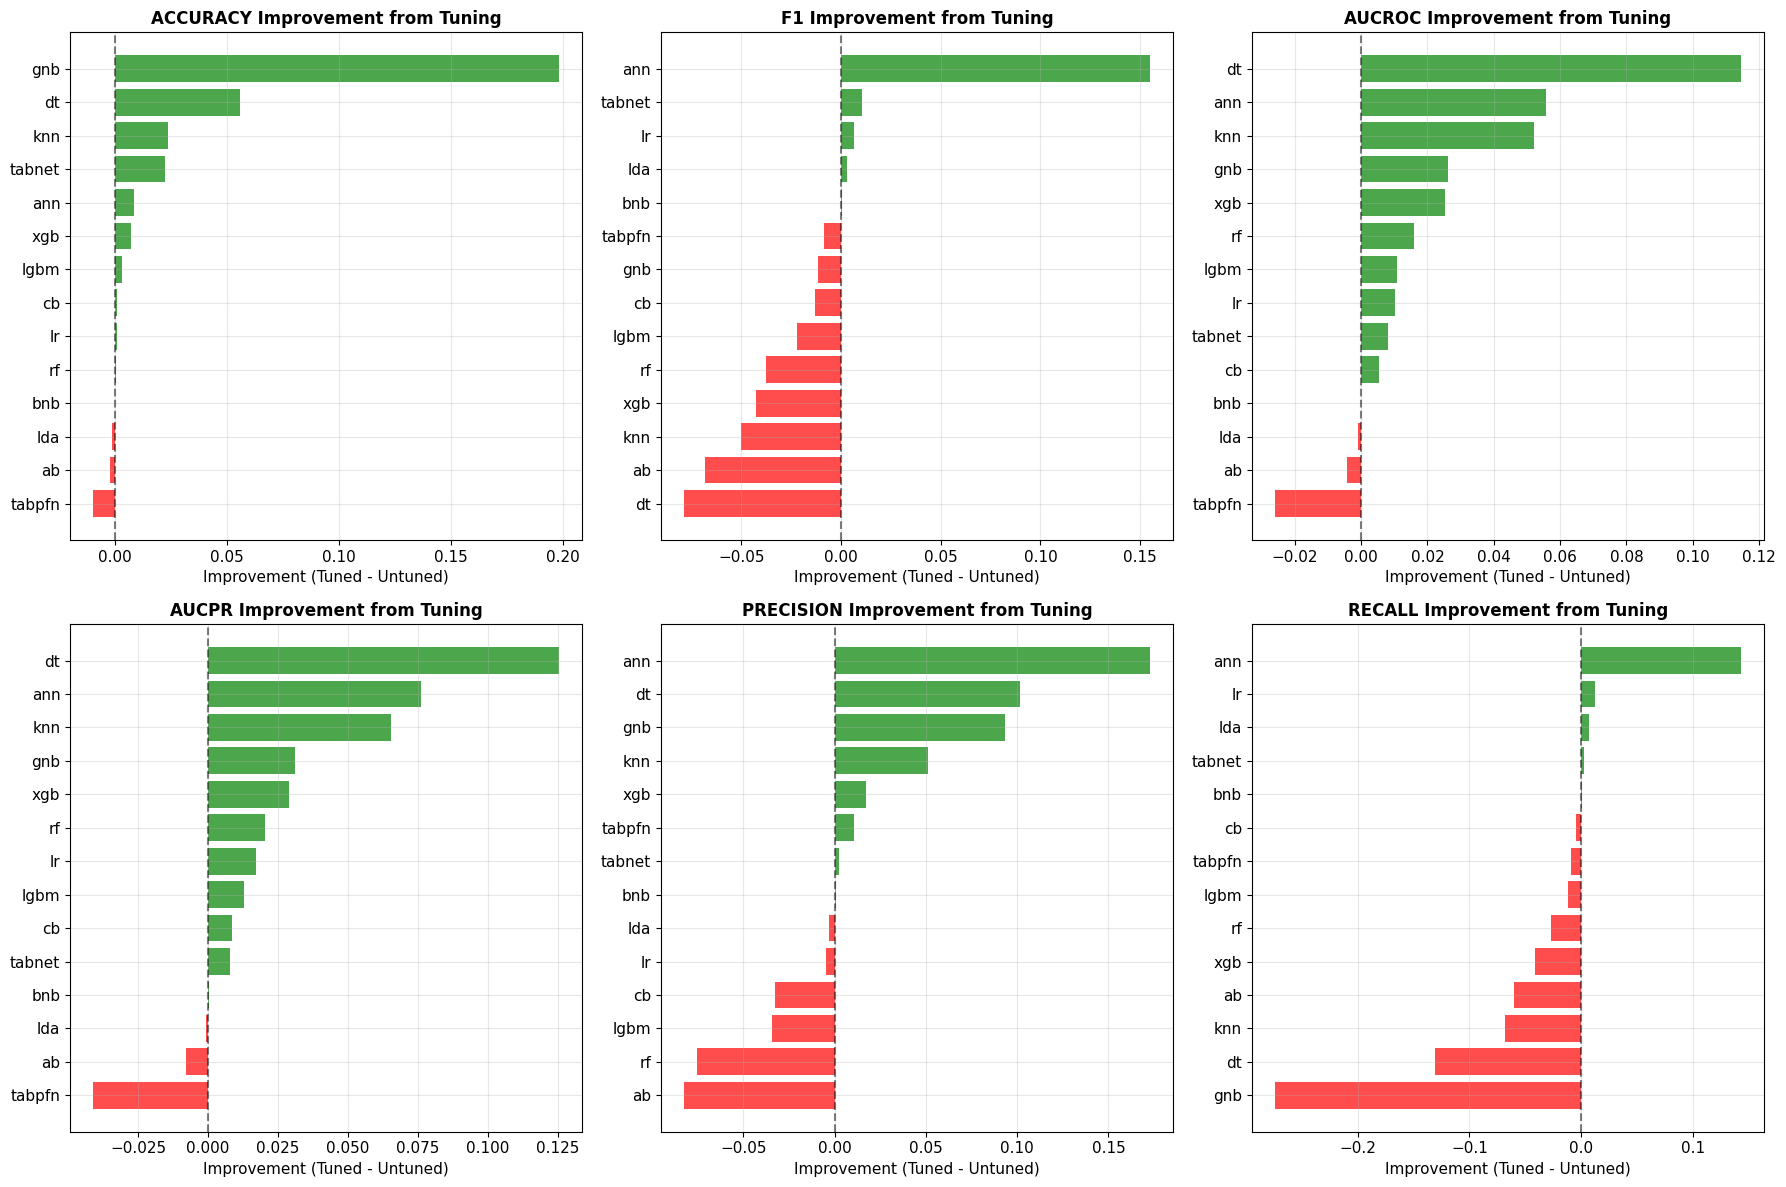


=== HYPERPARAMETER TUNING IMPACT ANALYSIS ===

Overall Tuning Impact by Metric:
          improvement                         pct_improvement           \
                 mean     std     min     max            mean      std   
metric                                                                   
accuracy       0.0218  0.0534 -0.0099  0.1982          3.7268   9.8651   
aucpr          0.0245  0.0410 -0.0411  0.1253          7.6506  13.5633   
aucroc         0.0210  0.0344 -0.0259  0.1145          3.2992   5.6050   
f1            -0.0112  0.0553 -0.0786  0.1548          2.0939  38.7163   
precision      0.0156  0.0697 -0.0823  0.1726          6.7073  19.7960   
recall        -0.0329  0.0912 -0.2736  0.1427         -0.5953  47.8730   

                              
               min       max  
metric                        
accuracy   -1.2008   37.1016  
aucpr      -8.3302   46.2262  
aucroc     -3.3995   19.3103  
f1        -24.7466  132.5931  
precision -15.5949   58.8336  
reca

In [4]:
# Calculate mean performance by model and tuning status
performance_metrics = ['accuracy', 'f1', 'aucroc', 'aucpr', 'precision', 'recall']

# Group by model and tuning to get mean performance
tuning_impact = df.groupby(['model', 'tuning'])[performance_metrics].mean().reset_index()

# Calculate the improvement from tuning for each model
tuning_comparison = []
for model in df['model'].unique():
    model_data = tuning_impact[tuning_impact['model'] == model]
    
    if len(model_data) == 2:  # Both tuned and untuned versions exist
        untuned = model_data[model_data['tuning'] == False].iloc[0]
        tuned = model_data[model_data['tuning'] == True].iloc[0]
        
        for metric in performance_metrics:
            improvement = tuned[metric] - untuned[metric]
            pct_improvement = (improvement / untuned[metric]) * 100 if untuned[metric] > 0 else 0
            
            tuning_comparison.append({
                'model': model,
                'metric': metric,
                'untuned': untuned[metric],
                'tuned': tuned[metric],
                'improvement': improvement,
                'pct_improvement': pct_improvement
            })

tuning_df = pd.DataFrame(tuning_comparison)

# Create visualization of tuning impact
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(performance_metrics):
    metric_data = tuning_df[tuning_df['metric'] == metric]
    
    # Sort by improvement
    metric_data_sorted = metric_data.sort_values('improvement', ascending=True)
    colors = ['green' if x >= 0 else 'red' for x in metric_data_sorted['improvement']]
    
    axes[i].barh(metric_data_sorted['model'], metric_data_sorted['improvement'], color=colors, alpha=0.7)
    axes[i].set_title(f'{metric.upper()} Improvement from Tuning', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Improvement (Tuned - Untuned)')
    axes[i].grid(True, alpha=0.3)
    axes[i].axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n=== HYPERPARAMETER TUNING IMPACT ANALYSIS ===")
print("\nOverall Tuning Impact by Metric:")
tuning_summary = tuning_df.groupby('metric')[['improvement', 'pct_improvement']].agg(['mean', 'std', 'min', 'max'])
print(tuning_summary.round(4))

print("\nModels with Largest Improvement from Tuning (by AUC-ROC):")
aucroc_improvements = tuning_df[tuning_df['metric'] == 'aucroc'].nlargest(5, 'improvement')
for _, row in aucroc_improvements.iterrows():
    print(f"{row['model']}: {row['improvement']:.4f} ({row['pct_improvement']:.2f}% improvement)")

print("\nModels with Largest Decline from Tuning (by AUC-ROC):")
aucroc_declines = tuning_df[tuning_df['metric'] == 'aucroc'].nsmallest(3, 'improvement')
for _, row in aucroc_declines.iterrows():
    print(f"{row['model']}: {row['improvement']:.4f} ({row['pct_improvement']:.2f}% change)")

## Class Imbalance Handling Effectiveness

Analysis of how different imbalance correction strategies affect model performance across different datasets.

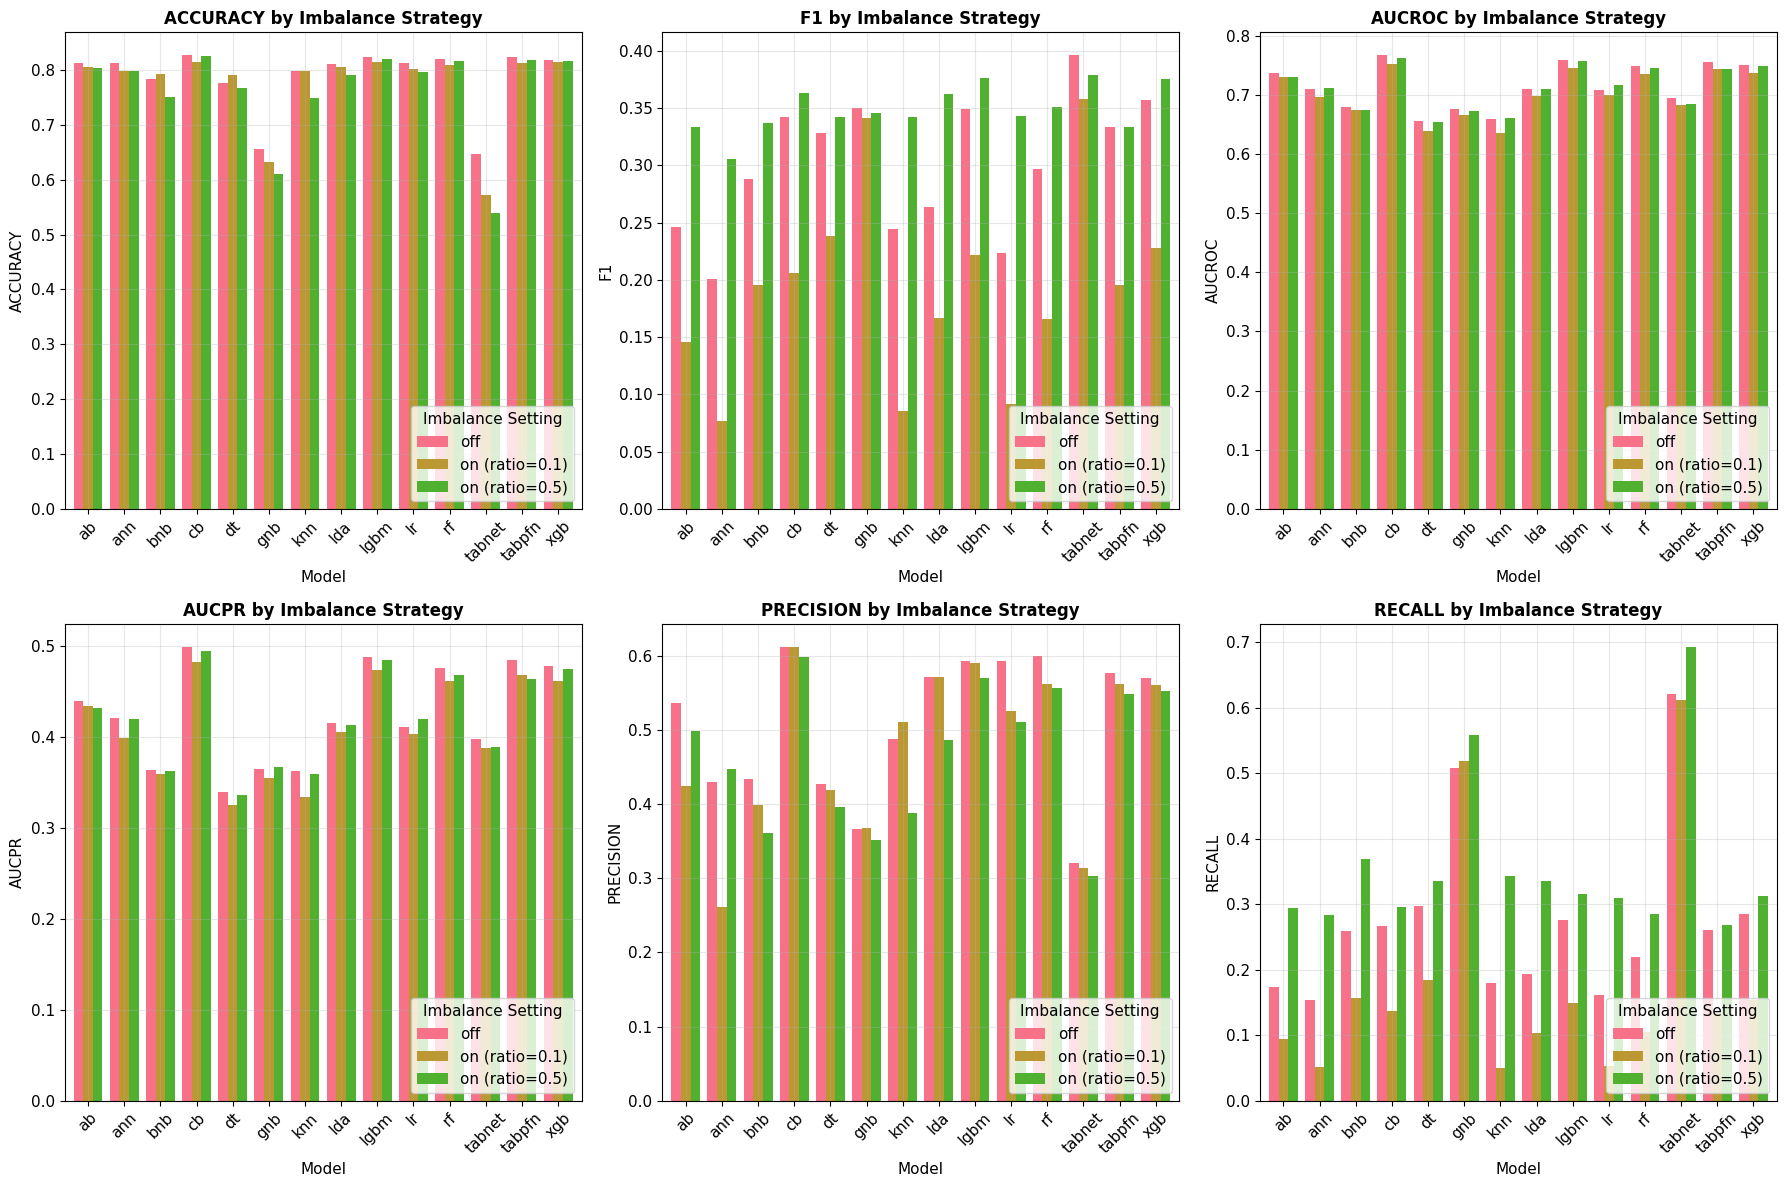


=== CLASS IMBALANCE HANDLING ANALYSIS ===

Mean Performance by Imbalance Strategy:
                   accuracy      f1  aucroc   aucpr  precision  recall
imbalance_setting                                                     
off                  0.7874  0.3015  0.7154  0.4243     0.5087  0.2751
on (ratio=0.1)       0.7760  0.1940  0.7028  0.4108     0.4775  0.1788
on (ratio=0.5)       0.7646  0.3495  0.7124  0.4203     0.4695  0.3569


In [5]:
# Analyze impact of imbalance handling strategies
imbalance_analysis = df.groupby(['imbalance_setting', 'model'])[performance_metrics].mean().reset_index()

# Create visualization for imbalance impact
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(performance_metrics):
    pivot_data = imbalance_analysis.pivot(index='model', columns='imbalance_setting', values=metric)
    
    # Create grouped bar chart
    pivot_data.plot(kind='bar', ax=axes[i], width=0.8)
    axes[i].set_title(f'{metric.upper()} by Imbalance Strategy', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Model')
    axes[i].set_ylabel(metric.upper())
    axes[i].legend(title='Imbalance Setting', loc='lower right')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical analysis of imbalance strategies
print("\n=== CLASS IMBALANCE HANDLING ANALYSIS ===")
print("\nMean Performance by Imbalance Strategy:")
imbalance_summary = df.groupby('imbalance_setting')[performance_metrics].mean()
print(imbalance_summary.round(4))

## Top Performing Models by Performance Metric

Identification of the best-performing models for each metric, with separate consideration of tuned and untuned versions.

=== TOP PERFORMING MODELS BY METRIC ===

Top 5 Models for Each Performance Metric:

ACCURACY:
1. tabpfn (Untuned): 0.8239
2. cb (Tuned): 0.8230
3. cb (Untuned): 0.8222
4. lgbm (Tuned): 0.8207
5. xgb (Tuned): 0.8197

F1:
1. tabnet (Tuned): 0.3833
2. tabnet (Untuned): 0.3727
3. gnb (Untuned): 0.3520
4. dt (Untuned): 0.3423
5. xgb (Untuned): 0.3413

AUCROC:
1. cb (Tuned): 0.7636
2. tabpfn (Untuned): 0.7605
3. lgbm (Tuned): 0.7591
4. xgb (Tuned): 0.7586
5. cb (Untuned): 0.7583

AUCPR:
1. cb (Tuned): 0.4964
2. tabpfn (Untuned): 0.4928
3. lgbm (Tuned): 0.4886
4. cb (Untuned): 0.4877
5. xgb (Tuned): 0.4859

PRECISION:
1. cb (Untuned): 0.6243
2. rf (Untuned): 0.6108
3. lgbm (Untuned): 0.6022
4. cb (Tuned): 0.5918
5. xgb (Tuned): 0.5698

RECALL:
1. gnb (Untuned): 0.6652
2. tabnet (Tuned): 0.6433
3. tabnet (Untuned): 0.6407
4. gnb (Tuned): 0.3916
5. dt (Untuned): 0.3378



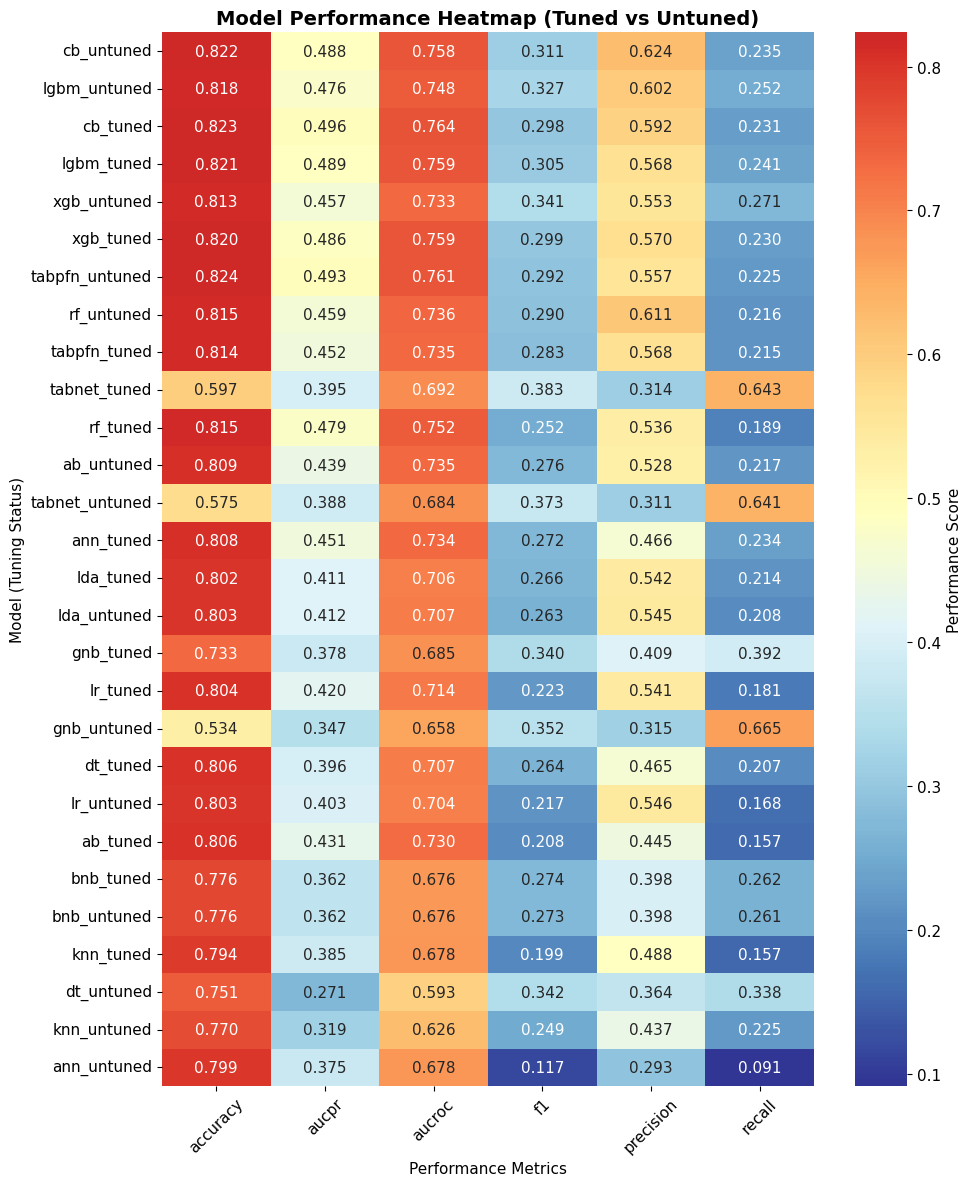


=== OVERALL BEST MODEL ANALYSIS ===

Top 10 Models Overall (Average across all metrics):
1. cb (Untuned): 0.5398
2. lgbm (Untuned): 0.5372
3. cb (Tuned): 0.5339
4. lgbm (Tuned): 0.5304
5. xgb (Untuned): 0.5280
6. xgb (Tuned): 0.5271
7. tabpfn (Untuned): 0.5252
8. rf (Untuned): 0.5211
9. tabpfn (Tuned): 0.5112
10. tabnet (Tuned): 0.5041

=== BEST TUNED VS UNTUNED COMPARISON ===
ab: Untuned wins (Δ = -0.0375)
ann: Tuned wins (Δ = 0.1017)
bnb: Tuned wins (Δ = 0.0004)
cb: Untuned wins (Δ = -0.0059)
dt: Tuned wins (Δ = 0.0313)
gnb: Tuned wins (Δ = 0.0106)
knn: Tuned wins (Δ = 0.0124)
lda: Tuned wins (Δ = 0.0005)
lgbm: Untuned wins (Δ = -0.0068)
lr: Tuned wins (Δ = 0.0070)
rf: Untuned wins (Δ = -0.0173)
tabnet: Tuned wins (Δ = 0.0089)
xgb: Untuned wins (Δ = -0.0009)
tabpfn: Untuned wins (Δ = -0.0140)

=== STATISTICAL SIGNIFICANCE TESTS ===
AUCROC - Tuned vs Untuned:
  Tuned mean: 0.7207 (±0.1025)
  Untuned mean: 0.6997 (±0.1080)
  t-statistic: 5.6995, p-value: 0.000000
  Significance: ***



In [6]:
# Calculate mean performance for each model-tuning combination
model_performance = df.groupby(['model', 'tuning'])[performance_metrics].mean().reset_index()
model_performance['model_tuned'] = model_performance['model'] + '_' + model_performance['tuning'].map({True: 'tuned', False: 'untuned'})

# Find top performers for each metric
print("=== TOP PERFORMING MODELS BY METRIC ===")
print("\nTop 5 Models for Each Performance Metric:\n")

top_performers = {}
for metric in performance_metrics:
    top_5 = model_performance.nlargest(5, metric)[['model_tuned', 'model', 'tuning', metric]]
    top_performers[metric] = top_5
    
    print(f"{metric.upper()}:")
    for i, (_, row) in enumerate(top_5.iterrows(), 1):
        tuning_status = "(Tuned)" if row['tuning'] else "(Untuned)"
        print(f"{i}. {row['model']} {tuning_status}: {row[metric]:.4f}")
    print()

# Create heatmap of top performers
heatmap_data = model_performance.pivot_table(
    index='model_tuned', 
    values=performance_metrics, 
    aggfunc='mean'
)

# Sort by overall performance (mean of all metrics)
heatmap_data['overall_score'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('overall_score', ascending=False)
heatmap_data = heatmap_data.drop('overall_score', axis=1)

# Create heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, annot=True, cmap='RdYlBu_r', center=heatmap_data.mean().mean(), 
            fmt='.3f', cbar_kws={'label': 'Performance Score'})
plt.title('Model Performance Heatmap (Tuned vs Untuned)', fontsize=14, fontweight='bold')
plt.xlabel('Performance Metrics')
plt.ylabel('Model (Tuning Status)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Overall best model analysis
print("\n=== OVERALL BEST MODEL ANALYSIS ===")
model_performance['overall_rank'] = model_performance[performance_metrics].mean(axis=1)
overall_best = model_performance.nlargest(10, 'overall_rank')

print("\nTop 10 Models Overall (Average across all metrics):")
for i, (_, row) in enumerate(overall_best.iterrows(), 1):
    tuning_status = "(Tuned)" if row['tuning'] else "(Untuned)"
    print(f"{i}. {row['model']} {tuning_status}: {row['overall_rank']:.4f}")

# Compare best tuned vs untuned versions of each model
print("\n=== BEST TUNED VS UNTUNED COMPARISON ===")
for model in df['model'].unique():
    model_data = model_performance[model_performance['model'] == model]
    if len(model_data) == 2:
        tuned = model_data[model_data['tuning'] == True]['overall_rank'].iloc[0]
        untuned = model_data[model_data['tuning'] == False]['overall_rank'].iloc[0]
        improvement = tuned - untuned
        winner = "Tuned" if improvement > 0 else "Untuned" if improvement < 0 else "Tie"
        print(f"{model}: {winner} wins (Δ = {improvement:.4f})")

# Statistical significance testing
print("\n=== STATISTICAL SIGNIFICANCE TESTS ===")
for metric in ['aucroc', 'f1', 'accuracy']:
    tuned_scores = df[df['tuning'] == True][metric]
    untuned_scores = df[df['tuning'] == False][metric]
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(tuned_scores, untuned_scores)
    
    print(f"{metric.upper()} - Tuned vs Untuned:")
    print(f"  Tuned mean: {tuned_scores.mean():.4f} (±{tuned_scores.std():.4f})")
    print(f"  Untuned mean: {untuned_scores.mean():.4f} (±{untuned_scores.std():.4f})")
    print(f"  t-statistic: {t_stat:.4f}, p-value: {p_value:.6f}")
    print(f"  Significance: {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}\n")

## Summary

In [7]:
print("="*80)
print("EVALUATION SUMMARY")
print("="*80)

# Key metrics for summary
overall_best = df.groupby('model_tuned')['aucroc'].mean().nlargest(5)

print("\nTOP PERFORMING MODELS (AUC-ROC):")
for i, (model, score) in enumerate(overall_best.items(), 1):
    print(f"{i}. {model}: {score:.4f}")

# Impact of tuning analysis
tuned_performance = df[df['tuning'] == True]['aucroc'].mean()
untuned_performance = df[df['tuning'] == False]['aucroc'].mean()
tuning_improvement = tuned_performance - untuned_performance

print(f"\nHYPERPARAMETER TUNING IMPACT:")
print(f"• Average AUC-ROC (Tuned): {tuned_performance:.4f}")
print(f"• Average AUC-ROC (Untuned): {untuned_performance:.4f}")
print(f"• Average improvement from tuning: {tuning_improvement:.4f} ({(tuning_improvement/untuned_performance)*100:.2f}%)")

# Count models that improve vs decline with tuning
tuning_winners = sum(1 for _, row in tuning_df[tuning_df['metric'] == 'aucroc'].iterrows() if row['improvement'] > 0)
total_models_compared = len(tuning_df[tuning_df['metric'] == 'aucroc'])

print(f"• Models improved by tuning: {tuning_winners}/{total_models_compared} ({(tuning_winners/total_models_compared)*100:.0f}%)")

print("\n" + "="*80)
print("Analysis based on 3,279 experiments across 13 datasets and 14 models")
print(f"Total model-tuning combinations evaluated: {df['model_tuned'].nunique()}")
print("Evaluation period: August 2025")
print("="*80)

EVALUATION SUMMARY

TOP PERFORMING MODELS (AUC-ROC):
1. cb_tuned: 0.7636
2. tabpfn_untuned: 0.7605
3. lgbm_tuned: 0.7591
4. xgb_tuned: 0.7586
5. cb_untuned: 0.7583

HYPERPARAMETER TUNING IMPACT:
• Average AUC-ROC (Tuned): 0.7207
• Average AUC-ROC (Untuned): 0.6997
• Average improvement from tuning: 0.0210 (3.00%)
• Models improved by tuning: 10/14 (71%)

Analysis based on 3,279 experiments across 13 datasets and 14 models
Total model-tuning combinations evaluated: 28
Evaluation period: August 2025
